In [262]:
# imports
import json, re, time, unicodedata, unidecode, itertools, os
from collections import defaultdict
from datetime import date, datetime, timedelta
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from pattern.nl import sentiment, parse, split
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import matplotlib.pyplot as plt

In [263]:
# files
#MWE
#topics = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\MWE_topic.json'))
#posts = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\MWE.json'))
#regular
forums = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-35-45 _amazones_forums_export.json'))
# zorg voor een nieuwe versie van dit bestand; verkeerd opgeslagen dus je mist het kontje!
topics = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-36-51_amazones_forum_topics_export.json'))
posts = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-39-20_amazones_forum_posts_export.json'))
users = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-39-20_amazones_users_export.json'))

IOError: [Errno 2] No such file or directory: 'D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-35-45 _amazones_forums_export.json'

In [3]:
def remove_non_ascii(text):
    """ this function expects a string, and removes non-ascii characters from it """
    return unidecode.unidecode(text)

In [4]:
def cleanup(text):
    """ this function expects a string (post from the BVN/Amazones forum), and returns a cleaner version of it """
    # remove all links, images, quotes, and emailaddresses
    text=re.sub('<a.*?>(.*?)</a>','',text) #remove links
    text=re.sub('(http:|www)\S*','',text) #remove links without markup
    text=re.sub('\[\\\/url\]','',text)
    text=re.sub('<img.*?/>', '',text) #remove images
    text=re.sub('<div class="bb-quote">((\s|\S)*?)</div>','',text) #remove quotes
    text=re.sub('<script.*?>([\S\s]*?)</script>','',text) #remove emailaddresses

    # replace all emoticon-icons
    text=re.sub('<img.*?title="(.*?)".*?/>', '(EMO:\\1)',text) #replace emoticons by textual indicators 

    # replace (most) sideways latin emoticons
    text=re.sub('[^>]:-?(\)|\])','(EMO:smiley)',text)
    text=re.sub(u'☺️','(EMO:smiley)',text)
    text=re.sub('[^>]:-?(\(|\[)','(EMO:sad)',text)
    text=re.sub(';-?(\)|\])','(EMO:wink)',text)
    text=re.sub(r'(:|;|x|X)-?(D)+\b','(EMO:laugh)',text)
    text=re.sub(':-?(/|\\\|\|)','(EMO:frown)',text)
    text=re.sub(r'(:|;)-?(p|P)+\b','(EMO:cheeky)',text)
    text=re.sub('(:|;)(\'|\")-?(\(|\[)','(EMO:cry)',text)
    text=re.sub('\<3+','(EMO:heart)',text)
    text=re.sub(u'❤️','(EMO:heart)',text)
    text=re.sub('((\>:-?(\(|\]))|(\>?:-?@))','(EMO:angry)',text)
    text=re.sub('\>:-?(\)|\])','(EMO:evil)',text)
    text=re.sub(r'(:|;)-?(O|o|0)+\b','(EMO:shock)',text)
    text=re.sub('(:|;)-?(K|k|x|X)','(EMO:kiss)',text)
    # :s
    # :x is eigenlijk geen kus, geloof ik...

    #other important adjustments:
    text=re.sub('m\'?n\s','mijn ',text) # replacing m'n and mn with mijn, so it gets parsed correctly.
    text=re.sub('z\'?n\s','zijn ',text) #replacing z'n and zn with zijn
    text=re.sub('d\'?r\s','haar ',text) #replacing d'r and dr with zijn (only if followed by space, so dr. stays dr.)

    # replace all emoticons (and other things) written between double colons
    text=re.sub(':([a-zA-Z]+):','(EMO:\\1)',text)

    # remove remaining markup
    text=re.sub('</?(ol|style|b|p|em|u|i|strong|br|span|div|blockquote|li)(.*?)/?>','',text)
    text=re.sub('(\[|\]|\{|\})', '',text)

    # separate text from punctuation (may cause double/triple spaces - does not matter at this point)
    text = re.sub('(\.{2,}|/|\)|,|!|\?)','\\1 ',text) # space behind
    text=re.sub('(/|\()',' \\1',text) # space in front
    text=re.sub('(\w{2,})(\.|,)','\\1 \\2 ',text) #space 'between'

    return(remove_non_ascii(text))

In [5]:
def make_P_T_and_D(topics,posts):
    """ this function takes the .json files containing the thread starts and responses, and returns three things:
    [0]: a dictionary with the user-ID as key, and the post as value;
    [1]: a dictionary with the user-ID as key, and the time of posting as a value;
    [2]: a list of all datetimes present in the data (sorted by date, because the .json was already sorted) """
    P = defaultdict(list)
    T = defaultdict(list)
    D = []

    with tqdm(total=len(topics)) as pbar:
        for t in reversed(topics):
            pbar.update(1)
            P[t['Author uid']].append((cleanup(t["Body"]),1))
            T[t['Author uid']].append(t['Post date'])
            D.append(datetime.strptime(t['Post date'], '%d/%m/%Y - %H:%M'))

    with tqdm(total=len(posts)) as pbar:
        for p in reversed(posts):
            pbar.update(1)
            P[p['Auteur-uid']].append((cleanup(p["Body"]),0))
            T[p['Auteur-uid']].append(p['Datum van inzending'])
            D.append(datetime.strptime(p['Datum van inzending'], '%d/%m/%Y - %H:%M'))

    return (P,T,D)

In [92]:
def determine_active_users(include_only = []):
    global over_treshold
    
    if include_only == []:
        print 'include all'
        userlist = T
    else:
        userlist = include_only
        print 'userlist is what is specified between the brackets'
    
    for user in userlist:
        if len(T[user])<30 or len(T[user])>50: # picks users with more than 30 posts, not time bins!
            pass
        else:
            over_treshold.append(user)

In [94]:
def make_binlist(D,timetick=1):
    """ this function takes a list of dates (D), and generates a new list of dates,
    starting at 4:00 AM just before the earliest date in D, and ending at 4:00 just after the latest date in D,
    with fixed timeticks between all dates in the list.
    Optionally, the length of the timetick may be specified (in hours).
    """
    lower = min(D)
    upper = max(D)

    if lower.time()>=datetime.strptime('4:00','%H:%M').time():
        lower = lower.replace(hour = 4, minute = 0)
    else:
        lower = (lower+timedelta(days = -1)).replace(hour=4,minute=0)

    if upper.time()<datetime.strptime('12:00','%H:%M').time():
        upper = upper.replace(hour = 4, minute = 0)
    else:
        upper = (upper+timedelta(days=1)).replace(hour=4,minute=0)

    return([lower + timedelta(hours=x) for x in range(0, 24*(upper-lower).days, timetick)])

In [247]:
# these bodies contain (EMO:...). Many emoticons are actually analysed by pattern's sentiment miner, so see which can be reverted (within-sentence) 
def determine_questionmarks(body, Q=0):
    """ This function counts and returns the number of sentences in the provided input string
    that ends in at least one question mark """
    for sentence in sent_tokenize(body):
        if re.search('\?+', sentence):
            Q+=1
    if len(sent_tokenize(body))!=0:
        return float(Q)/float(len(sent_tokenize(body)))
    else:
        return 0

def determine_sentiment(body):
    """ this funciton determines and returns the average sentiment of sentences in the provided input string.
    It uses the pattern module to do so. Sentiment values may range from -1 to 1. """
    return np.mean([sentiment(sentence)[0] for sentence in sent_tokenize(body)]) 

def determine_subjectivity(body):
    """ This function determines and returns the average subjectivity of sentences in the provided input string.
    It uses the pattern module to do so. Subjectivity values may range from 0 to 1. """
    return np.mean([sentiment(sentence)[1] for sentence in sent_tokenize(body)]) 

def determine_post_length(body):
    """ This function determines and returns the length of the provided input string in sentences.
    It uses the nltk sent_tokenize function to do so. """
    return(len(sent_tokenize(body)))

def determine_sentence_length(body):
    """ This function determines and returns the average length of the sentences in the provided input string in words.
    It uses the nltk word_tokenize function to do so. """
    #word_tokenize also considers interpunction a word
    return np.mean([len(word_tokenize(sentence)) for sentence in sent_tokenize(body)])

def determine_PRoPortion(body,prp = ['PRP','PRP$'],firstperson = ['ik', 'me', 'mij', 'mijn', 'we', 'wij', 'ons', 'onze']):
    """ This function determines and returns the percentage of personal and possessive pronouns
    that occurs in first person (e.g., 'ik', 'wij', 'onze'). It uses pattern's split and parse functions to do so """
    personalpronouns = []
    firstpersonalpronouns = []

    for sentence in split(parse(body)):
        for word in sentence:
            if word.tag in prp:
                personalpronouns.append(word.string)

    for word in personalpronouns:
        if word.lower() in firstperson:
            firstpersonalpronouns.append(word)
    if len(personalpronouns)==0:
        return 0
    else:
        return float(len(firstpersonalpronouns))/float(len(personalpronouns))
    
def determine_death(user,lower):
    if user in deathdict:
        return (datetime.strptime(''.join(deathdict[user]),'%d/%m/%Y - %H:%M')-lower).days
    if user in livingdict:
        return (datetime.strptime(''.join(livingdict[user]),'%d/%m/%Y - %H:%M')-lower).days
    else:
        return float('nan')

In [193]:
def make_deathdict():
    due_day = []
    user_IDs = []

    userdeaths_df = pd.read_csv('user-deaths.csv', delimiter = ';')
    for i, user in enumerate(userdeaths_df['uid']):
        due_day.append(userdeaths_df['death'][i])
        user_IDs.append(str(user))

    deathdict = dict()
    for i,d in enumerate(due_day):
         deathdict[user_IDs[i]] = datetime.strptime(d, '%d/%m/%Y')
    return deathdict

In [194]:
make_deathdict().keys()

['1143',
 '1140',
 '1146',
 '2717',
 '3040',
 '1147',
 '1774',
 '3124',
 '933',
 '2464',
 '1069',
 '1090',
 '1098',
 '1403',
 '4037',
 '2998',
 '1552',
 '1554',
 '1821',
 '929',
 '2413',
 '4487',
 '3844',
 '926',
 '3247',
 '987',
 '2777',
 '1923',
 '3672',
 '4800',
 '1711',
 '1527',
 '2389',
 '917',
 '1131',
 '2287',
 '3263',
 '1745',
 '2830',
 '902',
 '904',
 '905',
 '5572',
 '1845',
 '2672',
 '1004',
 '3808',
 '1870',
 '3211',
 '2208',
 '3458',
 '1737',
 '2114',
 '1034',
 '1215',
 '4278',
 '1354',
 '2333',
 '2184',
 '1911',
 '1912',
 '966',
 '962',
 '968',
 '1748',
 '1452',
 '1101',
 '2103',
 '1514',
 '1204',
 '2636',
 '4456',
 '1814',
 '951',
 '1617',
 '1564',
 '2877',
 '1179',
 '1609',
 '2332',
 '2089',
 '1047',
 '2126',
 '3224',
 '2080',
 '940',
 '1683',
 '3199']

In [15]:
def make_deathdict_2():
    #deadlist = make_deathdict().keys()
    deaddict = defaultdict(list)
    
    for user in T:
        if len(T[user])<30:
            next
        else:
            deaddict[user].append(max([datetime.strptime(x,'%d/%m/%Y - %H:%M') for x in T[user]]).strftime('%d/%m/%Y - %H:%M'))
            
    return deaddict

In [16]:
deathdict = make_deathdict_2()

In [18]:
print(deathdict)

defaultdict(<type 'list'>, {u'3714': ['24/11/2013 - 16:29'], u'3557': ['01/01/2012 - 22:16'], u'3556': ['12/05/2013 - 12:45'], u'4149': ['08/12/2013 - 18:44'], u'3550': ['09/11/2017 - 22:34'], u'1940': ['25/02/2011 - 20:15'], u'3852': ['05/04/2013 - 13:44'], u'3858': ['15/05/2015 - 12:01'], u'2852': ['22/06/2016 - 14:02'], u'1493': ['25/07/2010 - 20:17'], u'1499': ['12/10/2009 - 19:01'], u'6095': ['04/12/2017 - 17:09'], u'1069': ['13/11/2011 - 11:44'], u'1702': ['17/09/2013 - 22:17'], u'5300': ['25/11/2017 - 18:17'], u'2317': ['08/05/2014 - 19:23'], u'2314': ['02/01/2012 - 14:25'], u'1062': ['28/06/2016 - 10:39'], u'2310': ['17/11/2009 - 22:40'], u'1087': ['05/09/2013 - 08:26'], u'1084': ['30/01/2006 - 18:21'], u'1080': ['25/06/2005 - 23:01'], u'3779': ['23/03/2015 - 18:44'], u'2825': ['23/01/2012 - 01:45'], u'2823': ['18/08/2017 - 21:50'], u'2541': ['14/11/2011 - 19:32'], u'2540': ['15/02/2014 - 16:15'], u'3026': ['30/11/2011 - 21:47'], u'2980': ['04/03/2012 - 23:52'], u'3023': ['25/0

In [49]:
# add ETD to files

path = "C:\Users\sternheimam\Desktop\my-notebook\user-csvs"

for filename in os.listdir(path):
    ETDlist = []
    user = re.search(r'[0-9]+',filename).group(0)
    lastPost = datetime.strptime(''.join(deathdict[user]), '%d/%m/%Y - %H:%M')
    data = pd.read_csv(os.path.join(path, filename))
    for timeStamp in data['Date & Time']:
        ETDlist.append((lastPost - (datetime.strptime(timeStamp, '%Y-%m-%d %H:%M:%S'))).days)
    data['ETD'] = ETDlist
    data.to_csv(os.path.join(path,filename),index=False)

In [254]:
# add churn_in_year to files

path = "C:\Users\sternheimam\Desktop\my-notebook\user-csvs"
new_path = "C:\Users\sternheimam\Desktop\my-notebook\user-csvs-excluded"

for filename in os.listdir(path):
    boolean_churn_list = []
    user = re.search(r'[0-9]+',filename).group(0)
    if user not in churndate:
        os.rename(os.path.join(path,filename), os.path.join(new_path,filename))
    else:
        last_access = churndate[user]
        data = pd.read_csv(os.path.join(path, filename))
        for timeStamp in data['Date & Time']:
            future_churn = 1 if ((datetime.strptime(timeStamp, '%Y-%m-%d %H:%M:%S')) +
                timedelta(days = 7)) > last_access else 0
            boolean_churn_list.append(future_churn)
        data['churnThisYear'] = boolean_churn_list
        data.to_csv(os.path.join(path,filename),index=False)

In [255]:
# how many posts do people post in the last year of their registration?
path = "C:\Users\sternheimam\Desktop\my-notebook\user-csvs"
ones = []
for filename in tqdm(os.listdir(path)):
    data = pd.read_csv(os.path.join(path, filename))
    ones.append(len([x for x in data['churnThisYear'] if x==1]))

A Jupyter Widget

In [ ]:
stoppers en niet-stoppers identificeren
kijk voor beiden wat er aan het stopmoment voroaf ging
kijk bijvoorbeeld een maand vooruit


[{u'user_id': u'18705', u'name': u'Faith2', u'roles': u'De Amazones User', u'last_login': u'16/04/2018 - 08:48', u'avatar': u'', u'created_date': u'16/04/2018 - 08:47', u'last_access': u'16/04/2018 - 08:48'}, {u'user_id': u'18703', u'name': u'Els 1403', u'roles': u'De Amazones User', u'last_login': u'15/04/2018 - 09:47', u'avatar': u'', u'created_date': u'15/04/2018 - 09:46', u'last_access': u'15/04/2018 - 10:11'}, {u'user_id': u'18701', u'name': u'CaroleSterckendries', u'roles': u'De Amazones User', u'last_login': u'14/04/2018 - 08:01', u'avatar': u'', u'created_date': u'14/04/2018 - 08:00', u'last_access': u'14/04/2018 - 08:07'}, {u'user_id': u'18699', u'name': u'misstammie35', u'roles': u'De Amazones User', u'last_login': u'13/04/2018 - 18:01', u'avatar': u'', u'created_date': u'13/04/2018 - 17:43', u'last_access': u'13/04/2018 - 19:02'}, {u'user_id': u'18697', u'name': u'MoniqueJvR', u'roles': u'De Amazones User', u'last_login': u'17/04/2018 - 16:30', u'avatar': u'', u'created_date

[{u'status': u'Actief', u'user_id': u'18707', u'name': u'brandlykally', u'roles': u'De Amazones User', u'last_login': u'', u'avatar': u'', u'created_date': u'16/04/2018 - 21:26', u'last_access': u''}, {u'status': u'Geblokkeerd', u'user_id': u'18706', u'name': u'quentinujo02821', u'roles': u'De Amazones User', u'last_login': u'', u'avatar': u'', u'created_date': u'16/04/2018 - 10:14', u'last_access': u''}, {u'status': u'Actief', u'user_id': u'18705', u'name': u'Faith2', u'roles': u'De Amazones User', u'last_login': u'16/04/2018 - 08:48', u'avatar': u'', u'created_date': u'16/04/2018 - 08:47', u'last_access': u'16/04/2018 - 08:48'}, {u'status': u'Geblokkeerd', u'user_id': u'18704', u'name': u'halliebolinger0', u'roles': u'De Amazones User', u'last_login': u'', u'avatar': u'', u'created_date': u'15/04/2018 - 21:46', u'last_access': u''}, {u'status': u'Actief', u'user_id': u'18703', u'name': u'Els 1403', u'roles': u'De Amazones User', u'last_login': u'15/04/2018 - 09:47', u'avatar': u'', u

In [ ]:
neem dagen ipv uren als bins
daarna weken ipv dagen

0.1912442396313364


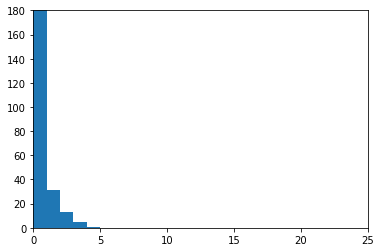

In [256]:
# with days = 365:

# out of 434 files:
# 175 are not going to quit in the next year (going off the plot here)
# 40 will post up to only hour in their last year
# 21 will post one to two hours
# 22 will post two to three hours
# 14 will post three to four hours
# 8 will post four to five hours
# the rest (154) will post more than 5 hours
# the maximum number of posts in the last year of forum participation is 214
# the median is 2
# the mean is 17,163594470046082
# however, I find it quite surprising that apparently most people quit the forum about a year after their last post
# there are only relatively few people who keep posting until right before they quit the forum
# (and do remember that some users still have the last post date as the last access date!)
print np.mean(ones)
plt.close()
bins = np.arange(0, max(ones), 1)
plt.hist(ones,bins = bins)
plt.xlim(0,25)
plt.ylim(0,180)
plt.show()

In [50]:
file1 = json.load(open('2018-04-18T13-08-47_amazones_users_export_last_access_from_2017_12_07.json'))
file2 = json.load(open('2018-04-18T13-21-05_amazones_users_export_all_with_status.json'))

In [ ]:
hoe ver kijk je terug en wat neem je mee voor iets dat je in het heden kan gebruiken
spelen met vooruit kijken; wel of geen churn zichtbaar
voor gradient boosting is het belangrijk om samen te vatten uit het verleden.

In [ ]:
je meet op elk moment al je variabelen
dan schuif je een dag vooruit
je kijkt een week vooruit of er churn i zicht is.
haal dat door lsdm


In [253]:
for f in file1:
    print f

{u'user_id': u'18705', u'name': u'Faith2', u'roles': u'De Amazones User', u'last_login': u'16/04/2018 - 08:48', u'avatar': u'', u'created_date': u'16/04/2018 - 08:47', u'last_access': u'16/04/2018 - 08:48'}
{u'user_id': u'18703', u'name': u'Els 1403', u'roles': u'De Amazones User', u'last_login': u'15/04/2018 - 09:47', u'avatar': u'', u'created_date': u'15/04/2018 - 09:46', u'last_access': u'15/04/2018 - 10:11'}
{u'user_id': u'18701', u'name': u'CaroleSterckendries', u'roles': u'De Amazones User', u'last_login': u'14/04/2018 - 08:01', u'avatar': u'', u'created_date': u'14/04/2018 - 08:00', u'last_access': u'14/04/2018 - 08:07'}
{u'user_id': u'18699', u'name': u'misstammie35', u'roles': u'De Amazones User', u'last_login': u'13/04/2018 - 18:01', u'avatar': u'', u'created_date': u'13/04/2018 - 17:43', u'last_access': u'13/04/2018 - 19:02'}
{u'user_id': u'18697', u'name': u'MoniqueJvR', u'roles': u'De Amazones User', u'last_login': u'17/04/2018 - 16:30', u'avatar': u'', u'created_date': u'

{u'user_id': u'18643', u'name': u'Menoke', u'roles': u'De Amazones User', u'last_login': u'22/03/2018 - 16:13', u'avatar': u'http://bvn.loc/sites/default/files/avatars/fd983061-5364-4bde-9dbf-53b753c24987.jpg', u'created_date': u'22/03/2018 - 16:12', u'last_access': u'14/04/2018 - 07:07'}
{u'user_id': u'18642', u'name': u'Marieke k', u'roles': u'De Amazones User', u'last_login': u'21/03/2018 - 20:23', u'avatar': u'', u'created_date': u'21/03/2018 - 20:21', u'last_access': u'21/03/2018 - 21:07'}
{u'user_id': u'18640', u'name': u'yaske', u'roles': u'De Amazones User', u'last_login': u'24/03/2018 - 10:50', u'avatar': u'', u'created_date': u'20/03/2018 - 19:52', u'last_access': u'24/03/2018 - 10:54'}
{u'user_id': u'18639', u'name': u'Robeer', u'roles': u'De Amazones User', u'last_login': u'20/03/2018 - 18:19', u'avatar': u'', u'created_date': u'20/03/2018 - 18:18', u'last_access': u'28/03/2018 - 13:07'}
{u'user_id': u'18636', u'name': u'ReneFeijen', u'roles': u'De Amazones User', u'last_lo

{u'user_id': u'18570', u'name': u'Moontje8', u'roles': u'De Amazones User', u'last_login': u'21/02/2018 - 21:36', u'avatar': u'', u'created_date': u'21/02/2018 - 21:35', u'last_access': u'02/03/2018 - 07:32'}
{u'user_id': u'18569', u'name': u'Marroe', u'roles': u'De Amazones User', u'last_login': u'21/02/2018 - 17:22', u'avatar': u'', u'created_date': u'21/02/2018 - 17:22', u'last_access': u'21/02/2018 - 18:12'}
{u'user_id': u'18568', u'name': u'Foekje Detmar', u'roles': u'De Amazones User', u'last_login': u'21/02/2018 - 17:04', u'avatar': u'', u'created_date': u'21/02/2018 - 17:04', u'last_access': u'21/02/2018 - 17:26'}
{u'user_id': u'18567', u'name': u'TanjaW', u'roles': u'De Amazones User', u'last_login': u'21/02/2018 - 13:48', u'avatar': u'', u'created_date': u'21/02/2018 - 13:48', u'last_access': u'21/02/2018 - 13:53'}
{u'user_id': u'18566', u'name': u'Maaike@TV', u'roles': u'De Amazones User', u'last_login': u'20/02/2018 - 22:35', u'avatar': u'', u'created_date': u'20/02/2018 - 

{u'user_id': u'18414', u'name': u'Annie Hertsenberg', u'roles': u'De Amazones User', u'last_login': u'25/01/2018 - 13:19', u'avatar': u'', u'created_date': u'25/01/2018 - 13:18', u'last_access': u'26/01/2018 - 00:01'}
{u'user_id': u'18412', u'name': u'Rijkie', u'roles': u'De Amazones User', u'last_login': u'24/01/2018 - 17:17', u'avatar': u'', u'created_date': u'24/01/2018 - 15:31', u'last_access': u'24/01/2018 - 17:24'}
{u'user_id': u'18411', u'name': u'Koekie', u'roles': u'De Amazones User', u'last_login': u'24/01/2018 - 07:45', u'avatar': u'', u'created_date': u'24/01/2018 - 06:37', u'last_access': u'24/01/2018 - 07:45'}
{u'user_id': u'18410', u'name': u'Silly297', u'roles': u'De Amazones User', u'last_login': u'23/01/2018 - 15:40', u'avatar': u'', u'created_date': u'23/01/2018 - 15:40', u'last_access': u'01/02/2018 - 09:23'}
{u'user_id': u'18408', u'name': u'juubie', u'roles': u'De Amazones User', u'last_login': u'04/02/2018 - 17:53', u'avatar': u'http://bvn.loc/sites/default/files

{u'user_id': u'18352', u'name': u'Hiz1985', u'roles': u'De Amazones User', u'last_login': u'29/12/2017 - 05:31', u'avatar': u'', u'created_date': u'29/12/2017 - 05:31', u'last_access': u'06/01/2018 - 18:59'}
{u'user_id': u'18351', u'name': u'Toppertje', u'roles': u'De Amazones User', u'last_login': u'28/12/2017 - 21:36', u'avatar': u'', u'created_date': u'28/12/2017 - 21:35', u'last_access': u'28/12/2017 - 21:55'}
{u'user_id': u'18350', u'name': u'Lot70', u'roles': u'De Amazones User', u'last_login': u'28/12/2017 - 19:10', u'avatar': u'', u'created_date': u'28/12/2017 - 19:07', u'last_access': u'20/02/2018 - 14:43'}
{u'user_id': u'18349', u'name': u'S@bien', u'roles': u'De Amazones User', u'last_login': u'28/12/2017 - 09:31', u'avatar': u'', u'created_date': u'28/12/2017 - 09:29', u'last_access': u'02/04/2018 - 10:08'}
{u'user_id': u'18348', u'name': u'Julanji', u'roles': u'De Amazones User', u'last_login': u'27/12/2017 - 22:41', u'avatar': u'', u'created_date': u'27/12/2017 - 22:31', 

{u'user_id': u'18225', u'name': u'ingy11', u'roles': u'De Amazones User', u'last_login': u'10/11/2017 - 10:18', u'avatar': u'', u'created_date': u'10/11/2017 - 00:12', u'last_access': u'11/02/2018 - 18:39'}
{u'user_id': u'18214', u'name': u'Simone73', u'roles': u'De Amazones User', u'last_login': u'04/11/2017 - 09:25', u'avatar': u'', u'created_date': u'04/11/2017 - 09:17', u'last_access': u'05/04/2018 - 21:07'}
{u'user_id': u'18200', u'name': u'gg', u'roles': u'De Amazones User', u'last_login': u'31/10/2017 - 15:12', u'avatar': u'', u'created_date': u'31/10/2017 - 15:10', u'last_access': u'30/12/2017 - 20:31'}
{u'user_id': u'18199', u'name': u'An25', u'roles': u'De Amazones User', u'last_login': u'31/10/2017 - 10:51', u'avatar': u'', u'created_date': u'31/10/2017 - 10:51', u'last_access': u'13/04/2018 - 15:29'}
{u'user_id': u'18197', u'name': u'Mya', u'roles': u'De Amazones User', u'last_login': u'29/01/2018 - 20:30', u'avatar': u'', u'created_date': u'29/10/2017 - 21:52', u'last_acce

{u'user_id': u'17677', u'name': u'Natasha241', u'roles': u'De Amazones User', u'last_login': u'12/04/2018 - 18:46', u'avatar': u'http://bvn.loc/sites/default/files/avatars/IMG_6177.JPG', u'created_date': u'05/07/2017 - 15:42', u'last_access': u'14/04/2018 - 20:48'}
{u'user_id': u'6122', u'name': u'Cooka', u'roles': u'De Amazones User', u'last_login': u'07/01/2018 - 15:09', u'avatar': u'', u'created_date': u'18/06/2017 - 21:55', u'last_access': u'07/01/2018 - 16:54'}
{u'user_id': u'889', u'name': u'Bianca Lamme', u'roles': u'Agenda redacteur, B-force redacteur, BRCA redacteur, De Amazones Redacteur, Monitor redacteur, Website beheerder, Website redacteur, Websiteredacteur', u'last_login': u'12/03/2018 - 16:47', u'avatar': u'', u'created_date': u'02/06/2017 - 11:34', u'last_access': u'18/04/2018 - 10:37'}
{u'user_id': u'6110', u'name': u'Bossy83', u'roles': u'De Amazones User', u'last_login': u'27/10/2017 - 21:59', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/20170505_214

{u'user_id': u'5895', u'name': u'karin22', u'roles': u'De Amazones User', u'last_login': u'18/04/2018 - 07:54', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/50_plus-63-8-2705072214-grappigekat_0.jpg', u'created_date': u'21/08/2016 - 16:12', u'last_access': u'18/04/2018 - 08:18'}
{u'user_id': u'5890', u'name': u'Bernadette43', u'roles': u'De Amazones User', u'last_login': u'22/03/2018 - 22:56', u'avatar': u'', u'created_date': u'16/08/2016 - 15:39', u'last_access': u'22/03/2018 - 22:56'}
{u'user_id': u'5871', u'name': u'Globetrotter', u'roles': u'De Amazones User', u'last_login': u'04/12/2017 - 13:27', u'avatar': u'', u'created_date': u'23/07/2016 - 13:38', u'last_access': u'18/04/2018 - 11:10'}
{u'user_id': u'5865', u'name': u'Abby', u'roles': u'De Amazones User', u'last_login': u'03/10/2017 - 16:16', u'avatar': u'', u'created_date': u'17/07/2016 - 15:02', u'last_access': u'15/04/2018 - 12:31'}
{u'user_id': u'5860', u'name': u'Akris', u'roles': u'De Amazones User', u'la

{u'user_id': u'91', u'name': u'elisabeth', u'roles': u'De Amazones Commissie, De Amazones Moderator, De Amazones Redacteur, De Amazones User, De Amazones Web-blogger, Monitor redacteur, Website beheerder, Website redacteur, Websiteredacteur', u'last_login': u'07/02/2018 - 07:38', u'avatar': u'', u'created_date': u'08/07/2015 - 17:09', u'last_access': u'07/02/2018 - 14:32'}
{u'user_id': u'91', u'name': u'elisabeth', u'roles': u'De Amazones Commissie, De Amazones Moderator, De Amazones Redacteur, De Amazones User, De Amazones Web-blogger, Monitor redacteur, Website beheerder, Website redacteur, Websiteredacteur', u'last_login': u'07/02/2018 - 07:38', u'avatar': u'', u'created_date': u'08/07/2015 - 17:09', u'last_access': u'07/02/2018 - 14:32'}
{u'user_id': u'91', u'name': u'elisabeth', u'roles': u'De Amazones Commissie, De Amazones Moderator, De Amazones Redacteur, De Amazones User, De Amazones Web-blogger, Monitor redacteur, Website beheerder, Website redacteur, Websiteredacteur', u'las

{u'user_id': u'5080', u'name': u'SarahB', u'roles': u'De Amazones User', u'last_login': u'25/01/2018 - 22:36', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/10711180_10204565934043297_585241081_n.jpg', u'created_date': u'14/06/2014 - 18:04', u'last_access': u'20/02/2018 - 22:36'}
{u'user_id': u'5048', u'name': u'Patries84', u'roles': u'De Amazones User', u'last_login': u'22/03/2018 - 12:49', u'avatar': u'', u'created_date': u'19/05/2014 - 12:50', u'last_access': u'22/03/2018 - 12:49'}
{u'user_id': u'5045', u'name': u'Anet', u'roles': u'De Amazones User', u'last_login': u'13/01/2018 - 12:54', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/image_70.jpg', u'created_date': u'17/05/2014 - 23:01', u'last_access': u'15/01/2018 - 11:10'}
{u'user_id': u'5012', u'name': u'smim', u'roles': u'De Amazones User', u'last_login': u'10/04/2018 - 23:39', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/vliegtuigje.jpg', u'created_date': u'25/04/2014 - 19:05', u'l

{u'user_id': u'4540', u'name': u'Deja', u'roles': u'De Amazones User', u'last_login': u'20/10/2017 - 11:58', u'avatar': u'', u'created_date': u'17/05/2013 - 15:49', u'last_access': u'26/03/2018 - 19:30'}
{u'user_id': u'4535', u'name': u'Winnie74', u'roles': u'De Amazones User', u'last_login': u'07/02/2018 - 07:35', u'avatar': u'', u'created_date': u'14/05/2013 - 15:53', u'last_access': u'07/02/2018 - 19:36'}
{u'user_id': u'4481', u'name': u'Stephanie73', u'roles': u'De Amazones User', u'last_login': u'26/03/2018 - 00:23', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/Garden.jpg', u'created_date': u'13/04/2013 - 01:10', u'last_access': u'26/03/2018 - 00:23'}
{u'user_id': u'4479', u'name': u'Charloisser', u'roles': u'De Amazones User', u'last_login': u'02/01/2018 - 09:58', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/gladiool.jpg', u'created_date': u'10/04/2013 - 09:41', u'last_access': u'02/01/2018 - 10:05'}
{u'user_id': u'4475', u'name': u'Antje68', u'rol

{u'user_id': u'4041', u'name': u'Shayenn', u'roles': u'De Amazones User', u'last_login': u'15/12/2017 - 13:01', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/image_2.jpg', u'created_date': u'06/09/2012 - 19:32', u'last_access': u'10/03/2018 - 18:16'}
{u'user_id': u'4016', u'name': u'Debbie34', u'roles': u'De Amazones User', u'last_login': u'19/11/2012 - 12:27', u'avatar': u'', u'created_date': u'26/08/2012 - 11:16', u'last_access': u'11/12/2017 - 14:11'}
{u'user_id': u'3945', u'name': u'San1982', u'roles': u'De Amazones User', u'last_login': u'16/03/2018 - 17:08', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/StormRain.jpg', u'created_date': u'20/07/2012 - 20:39', u'last_access': u'16/03/2018 - 19:28'}
{u'user_id': u'3908', u'name': u'Jadey67', u'roles': u'De Amazones User', u'last_login': u'14/02/2018 - 08:49', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/amazone_0.jpg', u'created_date': u'26/06/2012 - 10:28', u'last_access': u'16/04/2018 

{u'user_id': u'3140', u'name': u'Mik 72', u'roles': u'De Amazones User', u'last_login': u'08/12/2017 - 16:56', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/keep-calm-and-fdkk-2.png', u'created_date': u'27/02/2011 - 17:45', u'last_access': u'08/12/2017 - 17:05'}
{u'user_id': u'3106', u'name': u'mooi29', u'roles': u'De Amazones User', u'last_login': u'08/12/2017 - 15:36', u'avatar': u'', u'created_date': u'08/02/2011 - 22:21', u'last_access': u'27/12/2017 - 20:53'}
{u'user_id': u'3105', u'name': u'Technoboy', u'roles': u'De Amazones User', u'last_login': u'13/04/2018 - 20:53', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/afd.cees_.jpg', u'created_date': u'05/02/2011 - 20:38', u'last_access': u'13/04/2018 - 20:56'}
{u'user_id': u'3097', u'name': u'cajo', u'roles': u'De Amazones User', u'last_login': u'14/04/2018 - 14:44', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/winnie_the_pooh.jpg', u'created_date': u'01/02/2011 - 09:43', u'last_access'

{u'user_id': u'2349', u'name': u'Debby', u'roles': u'De Amazones User', u'last_login': u'15/01/2018 - 09:32', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/a58b72db028d3b386e14e7cabd97e0cf_1561.jpg', u'created_date': u'12/01/2009 - 09:35', u'last_access': u'16/01/2018 - 21:30'}
{u'user_id': u'2326', u'name': u'Jeanne57', u'roles': u'De Amazones User', u'last_login': u'24/01/2018 - 13:33', u'avatar': u'', u'created_date': u'10/12/2008 - 20:45', u'last_access': u'24/01/2018 - 13:36'}
{u'user_id': u'2234', u'name': u'Geraakt', u'roles': u'De Amazones User', u'last_login': u'16/03/2018 - 20:15', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/a58b72db028d3b386e14e7cabd97e0cf_1443.jpg', u'created_date': u'12/08/2008 - 13:36', u'last_access': u'16/03/2018 - 20:15'}
{u'user_id': u'2144', u'name': u'Artemis', u'roles': u'De Amazones User', u'last_login': u'14/03/2018 - 10:36', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/Artemis_Diana_Greek_Goddess_A

{u'user_id': u'1234', u'name': u'Bluebrest', u'roles': u'De Amazones User', u'last_login': u'13/02/2018 - 12:05', u'avatar': u'http://bvn.loc/sites/default/files/avatars/Blauwborst-5.jpg', u'created_date': u'02/10/2005 - 16:31', u'last_access': u'09/04/2018 - 23:10'}
{u'user_id': u'1160', u'name': u'Buskruit', u'roles': u'De Amazones User', u'last_login': u'30/10/2017 - 20:23', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/a58b72db028d3b386e14e7cabd97e0cf_267.gif', u'created_date': u'20/07/2005 - 22:18', u'last_access': u'02/04/2018 - 18:11'}
{u'user_id': u'1071', u'name': u'Bambie', u'roles': u'De Amazones User', u'last_login': u'09/02/2018 - 22:12', u'avatar': u'http://bvn.loc/sites/default/files/legacy_files/06.gif', u'created_date': u'13/03/2005 - 17:29', u'last_access': u'24/02/2018 - 01:18'}
{u'user_id': u'942', u'name': u'conny', u'roles': u'De Amazones User', u'last_login': u'28/09/2004 - 14:10', u'avatar': u'', u'created_date': u'28/09/2004 - 14:09', u'last_acce

In [61]:
files = [file1,file2] # also add the third one from the old set
lastaccess = defaultdict(set)

for f in files:
    for entry in f:
        lastaccess[entry['user_id']].add(entry['last_access'])
        # I have checked, and there are no users with several lastaccess dates. 
        # (some have several entries in the data, though. that's why i used the set 
        # instead of the list.)

In [65]:
len(lastaccess)

5630

In [63]:
lastpost = defaultdict(list)

for user in T:
    lastpost[user].add(max([datetime.strptime(x,'%d/%m/%Y - %H:%M') for x in T[user]]).strftime('%d/%m/%Y - %H:%M'))

# T moet gehergenereerd worden, nu door de nieuwe files ook mee te nemen.

In [64]:
len(lastpost)

2238

In [140]:
# the list of all users that obviously show that something went wrong with their accounts
# n = 140
exclusions = set()

In [257]:
print len(exclusions)

140


In [260]:
with open('exclude.txt','w') as f:
    for user in exclusions:
        print >>f, user

In [147]:
print len(churndate)

2098


In [142]:
#36 gebruikers die wel gepost hebben maar niet in de nieuwe files voorkomen (? raar)
for user in lastpost:
    if user not in lastaccess:
        exclusions.add(user)

In [145]:
# make a dictionary with a churndate for every user
churndate = dict()
# there are some users which have posted AFTER their 'last access' date. Weird, huh.
for user in lastpost:
    if user in lastaccess:
        last_post = datetime.strptime(''.join(lastpost[user]),'%d/%m/%Y - %H:%M')
        last_activity = datetime.strptime(''.join(lastaccess[user]),'%d/%m/%Y - %H:%M')
        if  last_post > last_activity:
            # exclude this user
            exclusions.add(user)
        else:
            churndate[user] = last_activity

In [6]:
PTD = make_P_T_and_D(topics,posts) 
P = PTD[0]
T = PTD[1]
D = PTD[2]

A Jupyter Widget

A Jupyter Widget

In [13]:
def compare_variables(user,x,y,colour):
    fig = plt.figure(1)
    plt.plot(x,y,colour, label = 'sentiment',alpha = 0.5) #magenta
    plt.title(user)
    plt.xlabel('days until churn')
    plt.ylabel('sentiment value')
    #plt.show()

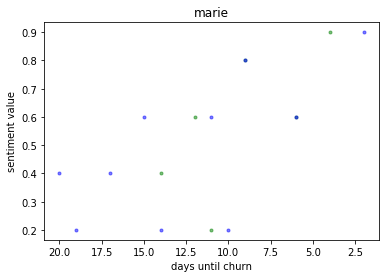

In [14]:
plt.close()
compare_variables('marie',[14,13,12,11,10,9,8,7,6,5,4,3,2,1],[0.4,float('nan'),0.6,0.2,float('nan'),0.8,float('nan'),float('nan'),0.6,float('nan'),0.9,float('nan'),float('nan'),float('nan')], 'g.')
compare_variables('marie',[20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1],[0.4,0.2,float('nan'),0.4,float('nan'),0.6,0.2,float('nan'),float('nan'),0.6,0.2,0.8,float('nan'),float('nan'),0.6,float('nan'),float('nan'),float('nan'),0.9,float('nan')], 'b.')
plt.gca().invert_xaxis()
plt.show()

In [132]:
max([datetime.strptime(x,'%d/%m/%Y - %H:%M') for x in T['2317']]).strftime('%d/%m/%Y - %H:%M')

'08/05/2014 - 19:23'

In [114]:
# ik wil de activiteit van 'de doden' vergelijken met die van 'de levenden'
deathdict = make_deathdict()

userlist = []
i = 0
for user in T:
    if i == 12: # waarom resulteert dit in een livingdict van 44 lang.......
        # hier komen we niet
        break
    else:
        if len(T[user])<=30 or len(T[user])>50:
            next
        else:
            if user not in deathdict:
                userlist.append(user)
                i+=1

livingdict = defaultdict(list)
for z in users:
    if z['Uid'] in userlist:
        livingdict[z['Uid']].append(max([datetime.strptime(x,'%d/%m/%Y - %H:%M') for x in T[z['Uid']]]).strftime('%d/%m/%Y - %H:%M')) # last login is inaccurate as fuck... (e.g., user 2317 is active for more than a year after 'last login'... yeah sure.)

# this livingdict is made of 88 still-living users, with their 'death date' on the date of their last activity.
# I have seen that is is possible to have this value empty. Decide what to do with those!

# now you could compare the behaviour of these two groups to each other:
# - maybe make a variable for the living that is similar to the variable for the death; how many days until quitting?
# - then you can map those values onto each other, and compare the two groups through time

In [283]:
for user in deathdict:
    if len(T[user])>30 and len(T[user])<50: #12 users (47 over 30)
        print user,deathdict[user], len(T[user])

2464 ['30/03/2010 - 23:16'] 44
4800 ['06/07/2015 - 20:11'] 44
1140 ['16/03/2007 - 19:40'] 40
1047 ['24/01/2006 - 22:49'] 33
1147 ['26/12/2006 - 13:46'] 38
951 ['22/02/2005 - 15:04'] 34
1098 ['17/01/2007 - 08:58'] 36
2332 ['19/09/2010 - 10:32'] 33
1354 ['18/12/2007 - 11:03'] 41
2672 ['29/03/2015 - 22:23'] 39
1911 ['17/09/2010 - 12:38'] 33
926 ['19/05/2016 - 15:40'] 43


In [116]:
for user in livingdict:
    print user,livingdict[user], len(T[user])

2309 ['20/04/2009 - 15:13'] 35
2053 ['21/11/2011 - 23:32'] 42
3349 ['01/05/2016 - 15:24'] 46
4284 ['23/02/2014 - 22:43'] 32
2317 ['08/05/2014 - 19:23'] 39
2305 ['13/11/2010 - 23:52'] 32
6142 ['15/01/2015 - 23:09'] 42
2209 ['24/02/2013 - 15:45'] 41
17826 ['01/10/2017 - 19:51'] 37
6148 ['29/01/2012 - 14:55'] 43
1753 ['02/05/2013 - 21:31'] 45
1750 ['18/01/2009 - 18:57'] 50


In [248]:
### path for saving csv files
path = r"C:\Users\sternheimam\Desktop\my-notebook\user-csvs-deathtest" 

#---------------------------
# global variables
#---------------------------
# chronological list of (lower) bin boundaries (default time tick = 1 hour)
binlist = make_binlist(D)
deathdict = make_deathdict_2()
all_dfs = []
# determine the negative difference for measuring the 'backtrack' feature
neg_diff = 24


#---------------------------
# determine 'relevant' users
#---------------------------
# initiate empty list of users relevant to measure
over_treshold = []
#deathdict.keys()+livingdict.keys() #2317 17826 3349= alive, ['1147','2464','1098'] = dead
determine_active_users(deathdict.keys()) # for practical reasons, right now only user 1144 is selected. If more users desired, simply enter them in list form.
# now, only users with more than 30 posts are selected. Later, users are evaluated again, to see if these posts are in at least 30 bins
#---------------------------
# go through all users in over_treshold, and do stuff..
#---------------------------
# show the progress, while going through the active users
with tqdm(total=len(over_treshold)) as processbar:
    for user in over_treshold:
        print user,
        processbar.update(1)
        
        #---------------------------
        # initiate some user-specific variables
        #---------------------------
        first_date = 0
        last_date = 0
        inactivity = 0
        
        # all lists starting with csv_ are lists that will eventually contain all values that end up in the csv file
        csv_date = []            #datetime
        csv_sentiment = []       #sentiment value (-1 to 1)
        #csv_questionmarks = []   #question mark-ending sentences (float)
        #csv_subjectivity = []    #subjectivity value (0 to 1)
        #csv_sentencelength = []  #length of sentence in words (float)
        #csv_postlength = []      #length of post in sentences (float)
        #csv_startposts = []      #1 for a thread start, 0 for a response (float) 
        #csv_inactivity = []      #hours passed since last activity (int)
        #csv_backtrack = []       #posts posted in last x hours (x = neg_diff; default 24h)
        #csv_firstpersonalpronouns = [] #first-person personal or possessive pronouns (float)
        csv_death_in_x_days = []
        
        # dictionaries to keep track of activity within certain time bins
        bindict = defaultdict(list)        #bins with size 'timetick' (default 1h), values = post-times 
        postdict = defaultdict(list)       #bins with size 'timetick' (default 1h), values = posts
        #metadict = defaultdict(list)       #bins with size 'timetick' (default 1h), values = 1 or 0 (start or response)
        #weekcountdict = defaultdict(list)  #bins with size = 7 days, values = '1' for every post
        #backtrackdict = defaultdict(list)  #bins with size = neg_diff (default 24h), values = nr of posts in last neg_diff hours

        # emoticons should be part of sentiment miner
        # TO DO: linguistic markers, like adjectives / pronouns, and the diversity of topics / vocabulary
        
        
        #---------------------------
        # loop through the (sorted) list of datetimes, and do stuff..
        #---------------------------
        for index,boundary in enumerate(tqdm(binlist)):
            # determine time bin boundaries for dictionaries
            if index+1>=len(binlist):
                break
            else:
                lower = binlist[index]
                upper = binlist[index+1]
                
                #---------------------------
                # Loop through T, collecting all activity for the selected user
                #---------------------------
                # determine in which time bin the user's activity belongs
                for time in T[user]:
                    if lower<=datetime.strptime(time, '%d/%m/%Y - %H:%M')<upper:
                        bindict[lower,upper].append(time)
                        
                        # and determine how active the user has been in past neg_diff hours
                        #past_activity = determine_past_activity(bindict,index,neg_diff)
                        #backtrackdict[lower,upper].append(past_activity)
                        
                        # determine the first and last active dates
                        if first_date == 0:
                            first_date = datetime.strptime(time, '%d/%m/%Y - %H:%M')
                            last_date = datetime.strptime(time, '%d/%m/%Y - %H:%M')
                        else:
                            last_date = datetime.strptime(time, '%d/%m/%Y - %H:%M')
                        
                        # split the text in P from the start/response-information
                        body = P[user][T[user].index(time)][0]
                        #meta = P[user][T[user].index(time)][1]                        
                        postdict[lower,upper].append(body) 
                        #metadict[lower,upper].append(meta)

                # fill up the still-empty places in the dictionary
                if len(bindict[lower,upper])==0:
                    bindict[lower,upper]=[]
                    postdict[lower,upper]=[]
                    #metadict[lower,upper]=[]
                    #backtrackdict[lower,upper]=[]
                
                #---------------------------
                # Fill csv_feature-lists with values 
                #---------------------------                
                # Treat different posts within same bin 'as one' (concatenate them)
                body = '. '.join(postdict[lower,upper]) #can be empty!
                
                # when then bin is empty, only add 1 to the inactivity feature
                if len(body) == 0:
                    #inactivity+=1
                    csv_date.append(float('nan'))
                    csv_death_in_x_days.append(float('nan'))
                    csv_sentiment.append(float('nan'))
                # when the bin is not empty, append a value to all csv_feature-lists (and reset 'inactivity')
                else:    
                    csv_date.append(lower)
                    csv_sentiment.append(determine_sentiment(body))
                    #csv_questionmarks.append(determine_questionmarks(body))
                    #csv_subjectivity.append(determine_subjectivity(body))
                    #csv_sentencelength.append(determine_sentence_length(body))
                    #csv_postlength.append(np.mean([determine_post_length(x) for x in postdict[lower,upper]]))
                    #csv_startposts.append(np.mean(metadict[lower,upper]))
                    #csv_inactivity.append(inactivity)
                    #csv_backtrack.append(np.sum(backtrackdict[lower,upper][-1]))
                    #csv_firstpersonalpronouns.append(determine_PRoPortion(body))
                    csv_death_in_x_days.append(determine_death(user,lower)) 
                    #inactivity = 0

        if len(csv_date) < 5:
            pass
        else: # only print results for users active in at least 30 time bins
            #---------------------------
            # Report the results for this user
            #--------------------------- 
            # determine average activity: over active period, and over only-active weeks 
            #weekcount = determine_week_activity(first_date,last_date,bindict)   
            #print_information(user, T, first_date,last_date,weekcount)            


            # put all csv_features into a dataframe
            df = pd.DataFrame({"Date & Time": csv_date, "Sentiment": csv_sentiment,# "Questions": csv_questionmarks, 
                               #"Subjectivity": csv_subjectivity, "Words/Sentence": csv_sentencelength, 
                               #"Sentences/Post": csv_postlength, "First posts": csv_startposts,
                               #"Inactivity": csv_inactivity, "Posts in last 24H": csv_backtrack,
                              #"PRP1": csv_firstpersonalpronouns, 
                               "ETD": csv_death_in_x_days}).dropna()
            #compare_variables(user, csv_sentiment, csv_death_in_x_days)
            all_dfs.append(df)
            #name = "death_user_"+str(user)+".csv"       
            #df.to_csv(os.path.join(path,name),index=False)
print "Done with all users. now generate a figure!"

userlist is what is specified between the brackets


A Jupyter Widget

2464

A Jupyter Widget

Exception in thread Thread-18:
Traceback (most recent call last):
  File "C:\Users\sternheimam\AppData\Local\Continuum\anaconda2\lib\threading.py", line 801, in __bootstrap_inner
    self.run()
  File "C:\Users\sternheimam\AppData\Local\Continuum\anaconda2\lib\site-packages\tqdm\_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\sternheimam\AppData\Local\Continuum\anaconda2\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 4800

A Jupyter Widget

 1140

A Jupyter Widget

 1047

A Jupyter Widget

 1147

A Jupyter Widget

 951

A Jupyter Widget

 1098

A Jupyter Widget

 2332

A Jupyter Widget

 1354

A Jupyter Widget

 2672

A Jupyter Widget

 1911

A Jupyter Widget

 926

A Jupyter Widget

 Done with all users. now generate a figure!


In [268]:
DEAD = all_dfs #1147
result = pd.concat(all_dfs)
result.to_csv('deaduser_lastpost.csv', index = True)

In [101]:
ALIVE = all_dfs #2317
result = pd.concat(all_dfs)
result.to_csv('livinguser.csv', index = True)

In [269]:
DEAD = pd.read_csv('deaduser_lastpost.csv')
ALIVE = pd.read_csv('livinguser.csv')

In [270]:
DEAD.columns = ['index', 'DateTime', 'ETD', 'Sentiment']
print DEAD.head()
ALIVE.columns = ['index', 'DateTime', 'ETD', 'Sentiment']
print ALIVE.head()

   index             DateTime    ETD  Sentiment
0  41681  2009-06-03 21:00:00  300.0  -0.072619
1  41682  2009-06-03 22:00:00  300.0   0.366667
2  41844  2009-06-10 16:00:00  293.0   0.017552
3  41860  2009-06-11 08:00:00  292.0   0.161607
4  41885  2009-06-12 09:00:00  291.0   0.124063
   index             DateTime    ETD  Sentiment
0  37093  2008-11-24 17:00:00  146.0   0.032813
1  38150  2009-01-07 18:00:00  102.0   0.053252
2  38264  2009-01-12 12:00:00   98.0   0.158333
3  38290  2009-01-13 14:00:00   97.0  -0.029514
4  38295  2009-01-13 19:00:00   96.0   0.039167


In [234]:
del s_a

In [281]:
s_d = DEAD.groupby(['ETD'])['Sentiment'].mean().reset_index() # this is the method i want to use, though perhaps concatenate some values
c_d = DEAD.groupby(['ETD'])['Sentiment'].count().reset_index([])

s_a = ALIVE.groupby(['ETD'])['Sentiment'].mean().reset_index()
c_a = ALIVE.groupby(['ETD'])['Sentiment'].count().reset_index([])


s_a['count'] = c_a
s_d['count'] = c_d

#print s_a
print s_d[40:60]

      ETD  Sentiment  count
40  115.0   0.103274      1
41  116.0  -0.039914      1
42  117.0   0.104167      1
43  118.0   0.157743      2
44  119.0   0.057353      1
45  120.0   0.031967      4
46  121.0  -0.015000      1
47  122.0   0.090212      6
48  123.0   0.168056      1
49  124.0   0.055147      3
50  125.0   0.048478      4
51  126.0   0.185795      1
52  127.0   0.021429      1
53  128.0   0.218750      2
54  129.0   0.133333      1
55  130.0   0.150000      1
56  131.0   0.147166      2
57  132.0   0.245883      1
58  134.0  -0.004786      3
59  145.0  -0.100000      1


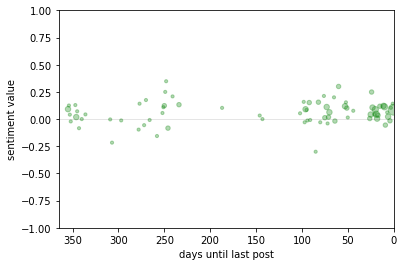

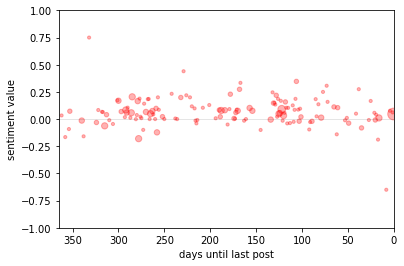

In [284]:
plt.close()
plt.axhline(0, linewidth=1, color = 'black', alpha = 0.1)
plt.scatter(s_a['ETD'], s_a['Sentiment'], color = 'g', alpha = 0.3, s = 10*s_a['count'])
plt.gca().invert_xaxis()
plt.xlabel('days until last post')
plt.ylabel('sentiment value')
plt.xlim(365,0)
plt.ylim(-1,1)
plt.show()
plt.axhline(0, linewidth=1, color = 'black', alpha = 0.1)
plt.scatter(s_d['ETD'], s_d['Sentiment'], color = 'r', alpha = 0.3, s=10*s_d['count'])
#A = s_a.plot(color = 'g')
#D = s_d.plot(color = 'r')
plt.gca().invert_xaxis()
plt.xlabel('days until last post')
plt.ylabel('sentiment value')
plt.xlim(365,0)
plt.ylim(-1,1)
plt.show()

In [244]:
import seaborn as sns

In [ ]:
sns.boxplot(x = 'ETD', y = 'log_price', data = train_df)

In [38]:
#dit is hoe je een dataframe.scatter maakt. beetje omslachtige shit, dus verander het eerder in de lijn ergens.
plt.close()
plt.scatter(result.groupby('ETD')['Sentiment'].mean().reset_index()['ETD'],result.groupby('ETD')['Sentiment'].mean().reset_index()['Sentiment'], 'r.')
plt.show()

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [298]:
time = '26/12/2006'
time2 = '21/10/2016'
print datetime.strptime(time, '%d/%m/%Y') - datetime.strptime(time2, '%d/%m/%Y')

-3587 days, 0:00:00


In [300]:
np.std([123,125,426,29,39,177,269,569,459,710,19,3587])

942.8754188945406

In [81]:
result = pd.concat(all_dfs, keys = ['1147']+['2317'])
result.to_csv('mini_df.csv', index = True)